In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

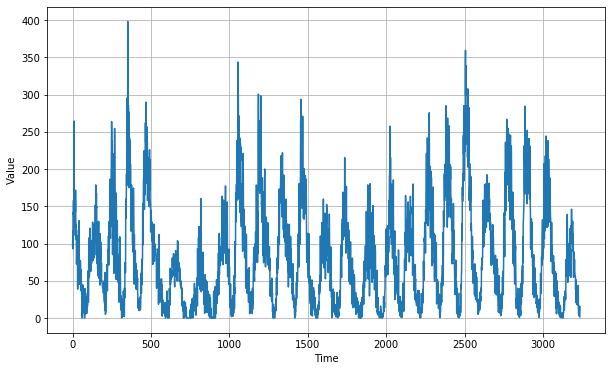

In [3]:
import csv
time_step = []
sunspots = []

with open('..//data/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

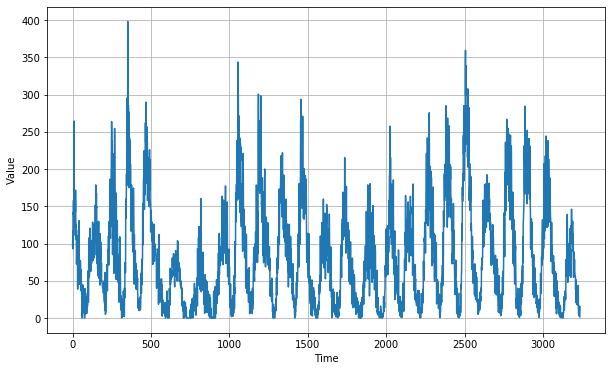

In [4]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 6s 531ms/step - loss: 80.3072 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 3s 234ms/step - loss: 77.9405 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 3s 236ms/step - loss: 75.2415 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 3s 239ms/step - loss: 72.2421 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 3s 237ms/step - loss: 68.5303 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 3s 264ms/step - loss: 64.8655 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 3s 287ms/step - loss: 61.1551 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 3s 264ms/step - loss: 58.2311 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 3s 260ms/step - loss: 54.7059 - mae: 55.5682
Epoch 10/100
12/

12/12 [==============================] - 3s 239ms/step - loss: 23.4105 - mae: 24.8199
Epoch 83/100
12/12 [==============================] - 3s 238ms/step - loss: 32.2223 - mae: 32.7575
Epoch 84/100
12/12 [==============================] - 3s 240ms/step - loss: 27.3758 - mae: 27.8569
Epoch 85/100
12/12 [==============================] - 3s 242ms/step - loss: 28.2014 - mae: 28.7715
Epoch 86/100
12/12 [==============================] - 3s 264ms/step - loss: 33.7510 - mae: 34.0702
Epoch 87/100
12/12 [==============================] - 3s 265ms/step - loss: 32.2405 - mae: 32.8612
Epoch 88/100
12/12 [==============================] - 3s 264ms/step - loss: 40.4057 - mae: 40.4310
Epoch 89/100
12/12 [==============================] - 3s 253ms/step - loss: 29.5379 - mae: 29.8389
Epoch 90/100
12/12 [==============================] - 3s 252ms/step - loss: 55.6631 - mae: 55.8453
Epoch 91/100
12/12 [==============================] - 3s 269ms/step - loss: 47.3559 - mae: 47.3795
Epoch 92/100
12/12 [===

[1e-08, 0.0001, 0, 60]

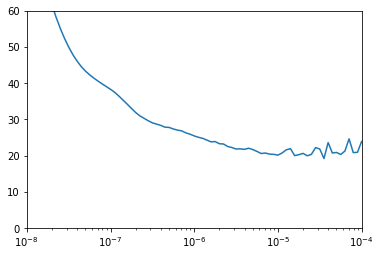

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 6s 205ms/step - loss: 37.8898 - mae: 38.6062
Epoch 2/500
30/30 [==============================] - 3s 94ms/step - loss: 24.1475 - mae: 24.6120
Epoch 3/500
30/30 [==============================] - 3s 107ms/step - loss: 22.0298 - mae: 22.5215
Epoch 4/500
30/30 [==============================] - 3s 101ms/step - loss: 19.8086 - mae: 20.3076
Epoch 5/500
30/30 [==============================] - 3s 98ms/step - loss: 19.4430 - mae: 19.9379
Epoch 6/500
30/30 [==============================] - 3s 96ms/step - loss: 19.2403 - mae: 19.7291
Epoch 7/500
30/30 [==============================] - 3s 95ms/step - loss: 18.5770 - mae: 19.0837
Epoch 8/500
30/30 [==============================] - 3s 97ms/step - loss: 18.5266 - mae: 19.0043
Epoch 9/500
30/30 [==============================] - 3s 103ms/step - loss: 18.1933 - mae: 18.7109
Epoch 10/500
30/30 [==============================] - 3s 112ms/step - loss: 18.1212 - mae: 18.6238
Epoch 11/500
30/30 [====

30/30 [==============================] - 3s 104ms/step - loss: 16.4222 - mae: 16.9166
Epoch 85/500
30/30 [==============================] - 3s 111ms/step - loss: 16.4673 - mae: 16.9609
Epoch 86/500
30/30 [==============================] - 3s 108ms/step - loss: 16.3652 - mae: 16.8628
Epoch 87/500
30/30 [==============================] - 3s 99ms/step - loss: 16.6144 - mae: 17.1192
Epoch 88/500
30/30 [==============================] - 3s 92ms/step - loss: 16.5243 - mae: 17.0394
Epoch 89/500
30/30 [==============================] - 3s 91ms/step - loss: 16.3981 - mae: 16.8852
Epoch 90/500
30/30 [==============================] - 3s 94ms/step - loss: 16.5498 - mae: 17.0293
Epoch 91/500
30/30 [==============================] - 3s 97ms/step - loss: 16.3579 - mae: 16.8518
Epoch 92/500
30/30 [==============================] - 3s 92ms/step - loss: 16.2935 - mae: 16.7949
Epoch 93/500
30/30 [==============================] - 3s 92ms/step - loss: 16.2964 - mae: 16.7935
Epoch 94/500
30/30 [==========

30/30 [==============================] - 3s 92ms/step - loss: 16.0366 - mae: 16.5150
Epoch 167/500
30/30 [==============================] - 3s 92ms/step - loss: 15.7844 - mae: 16.2777
Epoch 168/500
30/30 [==============================] - 3s 91ms/step - loss: 15.7918 - mae: 16.2915
Epoch 169/500
30/30 [==============================] - 3s 94ms/step - loss: 15.7841 - mae: 16.2818
Epoch 170/500
30/30 [==============================] - 3s 93ms/step - loss: 15.7851 - mae: 16.2690
Epoch 171/500
30/30 [==============================] - 3s 94ms/step - loss: 15.8365 - mae: 16.3323
Epoch 172/500
30/30 [==============================] - 3s 94ms/step - loss: 15.7452 - mae: 16.2377
Epoch 173/500
30/30 [==============================] - 3s 95ms/step - loss: 15.8158 - mae: 16.2964
Epoch 174/500
30/30 [==============================] - 3s 93ms/step - loss: 15.7507 - mae: 16.2401
Epoch 175/500
30/30 [==============================] - 3s 92ms/step - loss: 15.8284 - mae: 16.3189
Epoch 176/500
30/30 [===

30/30 [==============================] - 3s 92ms/step - loss: 15.3733 - mae: 15.8742
Epoch 249/500
30/30 [==============================] - 3s 92ms/step - loss: 15.3769 - mae: 15.8843
Epoch 250/500
30/30 [==============================] - 3s 93ms/step - loss: 15.4105 - mae: 15.8965
Epoch 251/500
30/30 [==============================] - 3s 92ms/step - loss: 15.2945 - mae: 15.7606
Epoch 252/500
30/30 [==============================] - 3s 90ms/step - loss: 15.3485 - mae: 15.8263
Epoch 253/500
30/30 [==============================] - 3s 92ms/step - loss: 15.2931 - mae: 15.7805
Epoch 254/500
30/30 [==============================] - 3s 95ms/step - loss: 15.2647 - mae: 15.7563
Epoch 255/500
30/30 [==============================] - 3s 91ms/step - loss: 15.2766 - mae: 15.7368
Epoch 256/500
30/30 [==============================] - 3s 93ms/step - loss: 15.2707 - mae: 15.7588
Epoch 257/500
30/30 [==============================] - 3s 94ms/step - loss: 15.2811 - mae: 15.7858
Epoch 258/500
30/30 [===

30/30 [==============================] - 3s 102ms/step - loss: 15.0212 - mae: 15.5032
Epoch 331/500
30/30 [==============================] - 3s 104ms/step - loss: 14.9254 - mae: 15.4027
Epoch 332/500
30/30 [==============================] - 3s 95ms/step - loss: 14.9155 - mae: 15.3941
Epoch 333/500
30/30 [==============================] - 3s 92ms/step - loss: 14.9124 - mae: 15.3939
Epoch 334/500
30/30 [==============================] - 3s 93ms/step - loss: 14.8317 - mae: 15.3285
Epoch 335/500
30/30 [==============================] - 3s 91ms/step - loss: 14.8803 - mae: 15.3575
Epoch 336/500
30/30 [==============================] - 3s 89ms/step - loss: 14.8438 - mae: 15.3355
Epoch 337/500
30/30 [==============================] - 3s 90ms/step - loss: 14.9365 - mae: 15.4286
Epoch 338/500
30/30 [==============================] - 3s 92ms/step - loss: 14.9680 - mae: 15.4328
Epoch 339/500
30/30 [==============================] - 3s 92ms/step - loss: 14.8504 - mae: 15.3548
Epoch 340/500
30/30 [=

30/30 [==============================] - 3s 103ms/step - loss: 14.5310 - mae: 15.0252
Epoch 413/500
30/30 [==============================] - 3s 97ms/step - loss: 14.5423 - mae: 15.0275
Epoch 414/500
30/30 [==============================] - 3s 98ms/step - loss: 14.4394 - mae: 14.9247
Epoch 415/500
30/30 [==============================] - 3s 99ms/step - loss: 14.5352 - mae: 15.0248
Epoch 416/500
30/30 [==============================] - 3s 95ms/step - loss: 14.6720 - mae: 15.1667
Epoch 417/500
30/30 [==============================] - 3s 95ms/step - loss: 14.4827 - mae: 14.9567
Epoch 418/500
30/30 [==============================] - 3s 102ms/step - loss: 14.3706 - mae: 14.8577
Epoch 419/500
30/30 [==============================] - 3s 97ms/step - loss: 14.7143 - mae: 15.1801
Epoch 420/500
30/30 [==============================] - 3s 93ms/step - loss: 14.3459 - mae: 14.8240
Epoch 421/500
30/30 [==============================] - 3s 94ms/step - loss: 14.6048 - mae: 15.1031
Epoch 422/500
30/30 [=

30/30 [==============================] - 3s 87ms/step - loss: 14.1301 - mae: 14.6033
Epoch 495/500
30/30 [==============================] - 3s 91ms/step - loss: 14.2169 - mae: 14.6963
Epoch 496/500
30/30 [==============================] - 3s 89ms/step - loss: 14.0011 - mae: 14.5052
Epoch 497/500
30/30 [==============================] - 3s 86ms/step - loss: 14.1231 - mae: 14.6241
Epoch 498/500
30/30 [==============================] - 3s 88ms/step - loss: 14.1958 - mae: 14.6940
Epoch 499/500
30/30 [==============================] - 3s 88ms/step - loss: 14.3917 - mae: 14.8654
Epoch 500/500
30/30 [==============================] - 3s 89ms/step - loss: 14.1773 - mae: 14.6765


In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

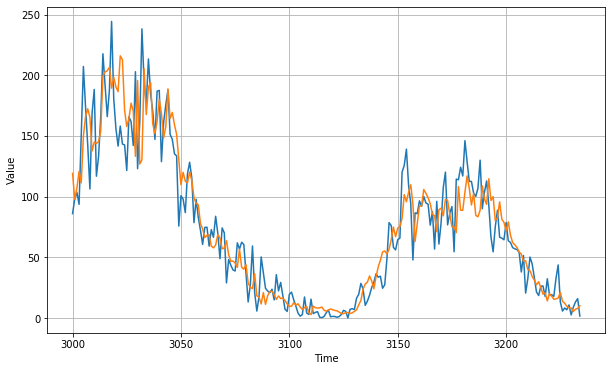

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.475901

<Figure size 432x288 with 0 Axes>

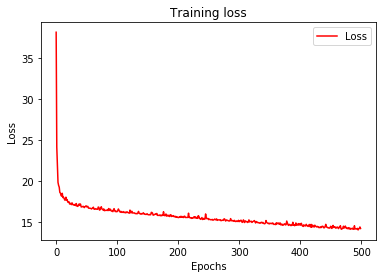

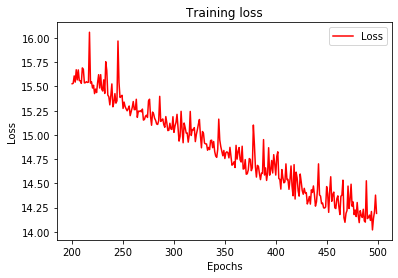

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [15]:
print(rnn_forecast)

[119.18278    97.729546  107.04295   120.68765   111.31041   149.76138
 166.23444   172.36063   165.23157   137.5556    144.92842   143.81738
 145.37775   153.9609    199.23103   202.69737   203.73048   206.51761
 189.32043   198.35818   190.33276   186.4991    215.9863    212.81805
 171.15231   157.70203   164.45464   176.99379   170.36884   133.20955
 195.58456   126.82809   130.24878   205.34595   167.63167   190.20033
 194.05927   159.83397   151.9924    162.09857   180.05847   168.49588
 148.32431   157.72816   188.73174   164.29967   169.32004   159.34575
 151.29715   131.01764   109.78705   120.003006  112.61936   111.25955
 120.29146   113.270805   99.18947    94.35757    93.2678     77.82258
  73.400375   66.25649    68.13059    68.60639    59.178482   57.7985
  60.098953   68.76119    65.78929    57.068283   57.58522    63.651474
  52.16514    46.660427   46.934315   45.257473   41.647194   56.67746
  41.77124    40.19002    44.052177   28.798002   25.04301    24.191458
  36.